#### Check if GPU is available
Please note that GPU will be required to train your model here. If you are running this in gsds server, follow the instruction below. You will have to use a command "launch-jupyter" to run jupyter notebook with GPU.

For those of you who received gsds server accounts for this class, use "class3" for your slurm partition.

https://gsds.gitbook.io/gsds/for-beginners/slurm

In [ ]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


#### Install Requried Packages if not installed in your environment

In [ ]:
!pip install datasets
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


#### Run this cell before you start

In [ ]:
import numpy as np
from datasets import load_dataset
from matplotlib import pyplot as plt
from transformers import AutoProcessor, Pix2StructForConditionalGeneration, Pix2StructProcessor
from torch.utils.data import Dataset, DataLoader

# 2. Fine-tune a pre-trained Image-to-Text model for Image Captioning

In this problem, you will load a pre-trained model, *pix2struct*, and fine-tune it to perform an image captioning task.

Pix2Struct is a pretrained image-to-text model for visual language understanding, and it has been fine-tuned on a variety of tasks and datasets, including image captioning and visual question answering. It is pretrained by learning to parse masked screenshots of web pages into simplified HTML. For more details about this model, please refer to the paper [here](https://arxiv.org/abs/2210.03347).

We will use a image captioning dataset from Hugging Face to fine-tune the model. The dataset contains Pokémon images with captions.

**(a)** Load the image captioning dataset. Split the data into training and validation set. **(4 pts)**

In [ ]:
data_path = "reach-vb/pokemon-blip-captions"

### YOUR CODE HERE (~4 lines)
### TODO:
### 1. Load dataset from the given data_path
### 2. Spit the dataset into train and validation set (10% will be used for our valid set) and save in 'train_set' and 'valid_set'
### Hint: use load_dataset and train_test_split. You can refer to the following document for 'datasets' library
### https://pypi.org/project/datasets/
dataset = load_dataset(data_path)
train_test_split = dataset['train'].train_test_split(test_size=0.1)
train_set = train_test_split['train']
valid_set = train_test_split['test']

### END YOUR CODE

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

(…)-00000-of-00001-566cc9b19d7203f8.parquet:   0%|          | 0.00/99.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/833 [00:00<?, ? examples/s]

In [ ]:
# If you run this cell, you will see a sample data in your training set.
print(train_set[0]["text"])
plt.imshow(train_set[0]["image"])

a very cute looking cartoon character with big eyes


In [ ]:
# If you run this cell, you will see a sample data in your validation set.

print(valid_set[0]["text"])
plt.imshow(valid_set[0]["image"])

a blue and white cartoon character running


### Pre-processing
DO NOT modify the code below for data preprocessing

In [ ]:
MAX_PATCHES = 16

class ICDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], return_tensors="pt",
                                  add_special_tokens=True, max_patches=MAX_PATCHES)
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        encoding["text"] = item["text"]
        return encoding


class my_collate(object):
    def __init__(self, processor, max_length):
        self.processor = processor
        self.max_length = max_length

    def __call__(self, batch):
       new_batch = {"flattened_patches":[], "attention_mask":[]}
       texts = [item["text"] for item in batch]

       text_inputs = self.processor(text=texts, padding="max_length", return_tensors="pt",
                                add_special_tokens=True, max_length=self.max_length)
       new_batch["labels"] = text_inputs.input_ids

       for item in batch:
          new_batch["flattened_patches"].append(item["flattened_patches"])
          new_batch["attention_mask"].append(item["attention_mask"])

       new_batch["flattened_patches"] = torch.stack(new_batch["flattened_patches"])
       new_batch["attention_mask"] = torch.stack(new_batch["attention_mask"])

       return new_batch


In [ ]:
# DO NOT modify below hyperparameters.
max_length = 20
batch_size = 2
model_path = "google/pix2struct-base"

processor = Pix2StructProcessor.from_pretrained(model_path)
my_collate_fn = my_collate(processor, max_length)

train_dataset = ICDataset(train_set, processor)
valid_dataset = ICDataset(valid_set, processor)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, collate_fn=my_collate_fn)
valid_loader = DataLoader(valid_dataset, shuffle=True, batch_size=batch_size, collate_fn=my_collate_fn)

sample_data = next(iter(train_loader))
print("Total number of training data :", len(train_loader.dataset))
print("Total number of test data :", len(valid_loader.dataset))
print("Flattened patches size: ", sample_data['flattened_patches'].size())
print("Attention mask size: ", sample_data['attention_mask'].size())
print("Label size: ", sample_data['labels'].size())

preprocessor_config.json:   0%|          | 0.00/231 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.61k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/851k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Total number of training data : 749
Total number of test data : 84
Flattened patches size:  torch.Size([2, 16, 770])
Attention mask size:  torch.Size([2, 16])
Label size:  torch.Size([2, 20])


### Load model and prepare for fine-tuning

In [ ]:
# DO NOT modify below hyperparameters.
LEARNING_RATE = 1e-5
model_path = "google/pix2struct-base"
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Pix2StructForConditionalGeneration.from_pretrained(model_path)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
print("Device :", device)   # cuda
print(model)

config.json:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.13G [00:00<?, ?B/s]

Device : cuda
Pix2StructForConditionalGeneration(
  (encoder): Pix2StructVisionModel(
    (embeddings): Pix2StructVisionEmbeddings(
      (patch_projection): Linear(in_features=768, out_features=768, bias=True)
      (row_embedder): Embedding(4096, 768)
      (column_embedder): Embedding(4096, 768)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): Pix2StructVisionEncoder(
      (layer): ModuleList(
        (0-11): 12 x Pix2StructVisionLayer(
          (attention): Pix2StructVisionAttention(
            (query): Linear(in_features=768, out_features=768, bias=False)
            (key): Linear(in_features=768, out_features=768, bias=False)
            (value): Linear(in_features=768, out_features=768, bias=False)
            (output): Linear(in_features=768, out_features=768, bias=False)
          )
          (mlp): Pix2StructVisionMlp(
            (wi_0): Linear(in_features=768, out_features=2048, bias=False)
            (wi_1): Linear(in_features=768, out_features=2048,

### Fine-tuning

Next, we will fine-tune the model to our dataset. Complete the train and evaluation code following the instruction in jupyter notebook file. It will take about 1 hour to train your model.

**(b)** Complete the training code in `train()` function of Trainer class. **(10 pts)**

**(c)** Complete the validation code in `train()` function of Trainer class. **(6 pts)**

**(d)** After the training is complete, use the `plot()` function of Trainer class to display the figure, and then paste it to your latex file. **(6 pts)**

**(e)** Based on your training results in (d), evaluate whether the training was successful, and write at least two ways to improve the model’s performance. **(4 pts)**

In [ ]:
class Trainer():
  def __init__(self, model, train_loader, valid_loader, optimizer):
    self.model = model
    self.train_loader = train_loader
    self.valid_loader = valid_loader
    self.optimizer = optimizer
    self.epoch_train_loss, self.epoch_val_loss = [], []

  def train(self, epochs):
    if self.epoch_train_loss:
      self.epoch_train_loss, self.epoch_val_loss = [], []

    for epoch in range(epochs):
      ########### TRAIN ###########
      self.model.train()
      train_losses = []
      for i, batch in enumerate(self.train_loader):
        ### YOUR CODE HERE (~9 lines)
        ### TODO:
        ###     1. Perform a forward pass on the loaded model.
        ###     2. Calculate the loss and perform backpropagation.
        ###     3. Save your loss in train_loss in float type.
        ###     4. Update the model's parameters using the optimizer.
        ### Hint: for input parameters of the model, refer to the below link. you can also check what's included in your batch in above cells.
        ###       https://huggingface.co/docs/transformers/v4.34.1/en/model_doc/pix2struct#transformers.Pix2StructForConditionalGeneration
        ### Hint: we can compute loss as we have 'labels' in our batch.
        inputs = {key: value.to(self.model.device) for key, value in batch.items()}
        outputs = self.model(**inputs)
        loss = outputs.loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        train_loss = loss.item()
        ### END YOUR CODE
        train_losses.append(train_loss)


      ######### VALIDATION #########
      val_losses = []
      self.model.eval()
      for i, batch in enumerate(self.valid_loader):
        ### YOUR CODE HERE (~6 lines)
        ### TODO:
        ###     1. Perform a forward pass on the loaded model.
        ###     2. Calculate the loss and save your loss in val_loss in float type.
        ### Hint: use the same approach you made in the previous question to get output and loss
        inputs = {key: value.to(self.model.device) for key, value in batch.items()}
        outputs = self.model(**inputs)
        loss = outputs.loss
        val_loss = loss.item()
        ### END YOUR CODE
        val_losses.append(val_loss)

      ### DO NOT modify below codes
      train_loss = np.mean(train_losses)
      val_loss = np. mean(val_losses)
      self.epoch_train_loss.append(train_loss)
      self.epoch_val_loss.append(val_loss)
      print(f'Epoch {epoch+1}')
      print(f'train_loss : {train_loss} val_loss : {val_loss}')

  def plot(self):
    fig = plt.figure(figsize = (20, 6))
    plt.plot(self.epoch_train_loss, label='Train loss')
    plt.plot(self.epoch_val_loss, label='Validation loss')
    plt.title("Loss")
    plt.legend()
    plt.grid()
    plt.show()

  def inference(self, image, processor):
    MAX_PATCHES=16
    device = "cuda" if torch.cuda.is_available() else "cpu"

    encoding = processor(images=image, return_tensors="pt", add_special_tokens=True, max_patches=MAX_PATCHES)
    encoding = encoding.to(device)

    flattened_patches = encoding['flattened_patches']
    attention_mask = encoding['attention_mask']

    generated_ids = model.generate(flattened_patches=flattened_patches, attention_mask=attention_mask)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)
    return generated_caption


In [ ]:
EPOCHS = 50
trainer= Trainer(model=model,
                 train_loader=train_loader,
                 valid_loader=valid_loader,
                 optimizer=optimizer)
trainer.train(EPOCHS)
trainer.plot()

Epoch 1
train_loss : 15.42725279744466 val_loss : 5.287870668229603
Epoch 2
train_loss : 4.831608157475789 val_loss : 2.735023464475359
Epoch 3
train_loss : 2.5009978726704913 val_loss : 1.2853683815115975
Epoch 4
train_loss : 1.5214871006011963 val_loss : 1.051282946552549
Epoch 5
train_loss : 1.2816188689867656 val_loss : 0.9985215791634151
Epoch 6
train_loss : 1.1772737148602803 val_loss : 0.961965357263883
Epoch 7
train_loss : 1.1190391428470612 val_loss : 0.9409283435060865
Epoch 8
train_loss : 1.0891105899810791 val_loss : 0.9153404271318799
Epoch 9
train_loss : 1.0247995510896046 val_loss : 0.9043688376744589
Epoch 10
train_loss : 1.0003152453104656 val_loss : 0.905227583079111
Epoch 11
train_loss : 0.9715936309496561 val_loss : 0.8932690861679259
Epoch 12
train_loss : 0.9610645956993104 val_loss : 0.8770703425010046
Epoch 13
train_loss : 0.9258592500686645 val_loss : 0.8702502406778789
Epoch 14
train_loss : 0.9263765664895376 val_loss : 0.8667938652492705
Epoch 15
train_loss : 

### Inference with your fine-tuned model

Load the image that you want to test

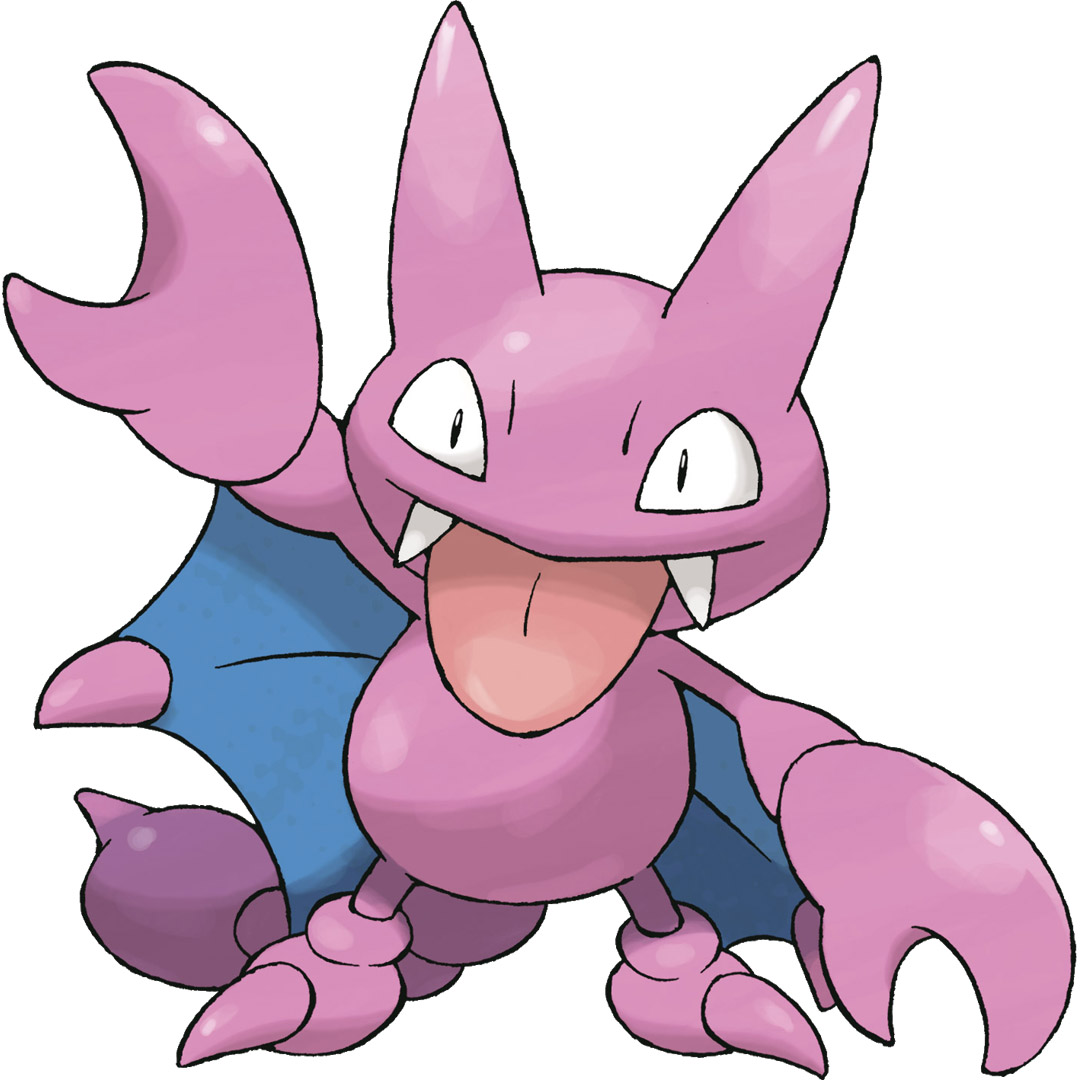

In [ ]:
from PIL import Image
import requests

url = "https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/pokemon.png"
image = Image.open(requests.get(url, stream=True).raw)
image

In [ ]:
generated_caption = trainer.inference(image, processor)
print(generated_caption)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['a drawing of a cartoon character with a sword']
